In [ ]:
# Import Libraries and Setup
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.metrics import Precision
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Print TensorFlow version and GPU availability
print(f"✅ TensorFlow version: {tf.__version__}")
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"🚀 GPU is available: {gpus[0].name}")
else:
    print("⚠️ No GPU found. Training will use CPU.")


✅ TensorFlow version: 2.10.1
🚀 GPU is available: /physical_device:GPU:0


In [ ]:
# GPU Configuration and Memory Growth
# Configure GPU memory growth to avoid OOM errors
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Num GPUs Available: {len(gpus)}")
        print("GPU memory growth enabled")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU available, using CPU")

Num GPUs Available: 1
GPU memory growth enabled


In [ ]:
# Configuration Parameters
IMAGE_H = 256
IMAGE_W = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50
LEARNING_RATE = 0.0001

In [ ]:
# Data Augmentation for Training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [ ]:
# Validation Data Generator
validation_datagen = ImageDataGenerator(
    rescale=1./255
)


In [ ]:
# Test Data Generator
test_datagen = ImageDataGenerator(
    rescale=1./255
)

In [ ]:
# Create Data Generators
train_generator = train_datagen.flow_from_directory(
    'Deepfake Image Dataset/train',
    target_size=(IMAGE_H, IMAGE_W),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    'Deepfake Image Dataset/val',
    target_size=(IMAGE_H, IMAGE_W),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    'Deepfake Image Dataset/test',
    target_size=(IMAGE_H, IMAGE_W),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)


Found 140002 images belonging to 2 classes.
Found 39428 images belonging to 2 classes.
Found 10905 images belonging to 2 classes.


In [ ]:
#Get Class Names
class_names = list(train_generator.class_indices.keys())
n_classes = len(class_names)
print(f"Classes: {class_names}")
print(f"Number of classes: {n_classes}")

Classes: ['Fake', 'Real']
Number of classes: 2


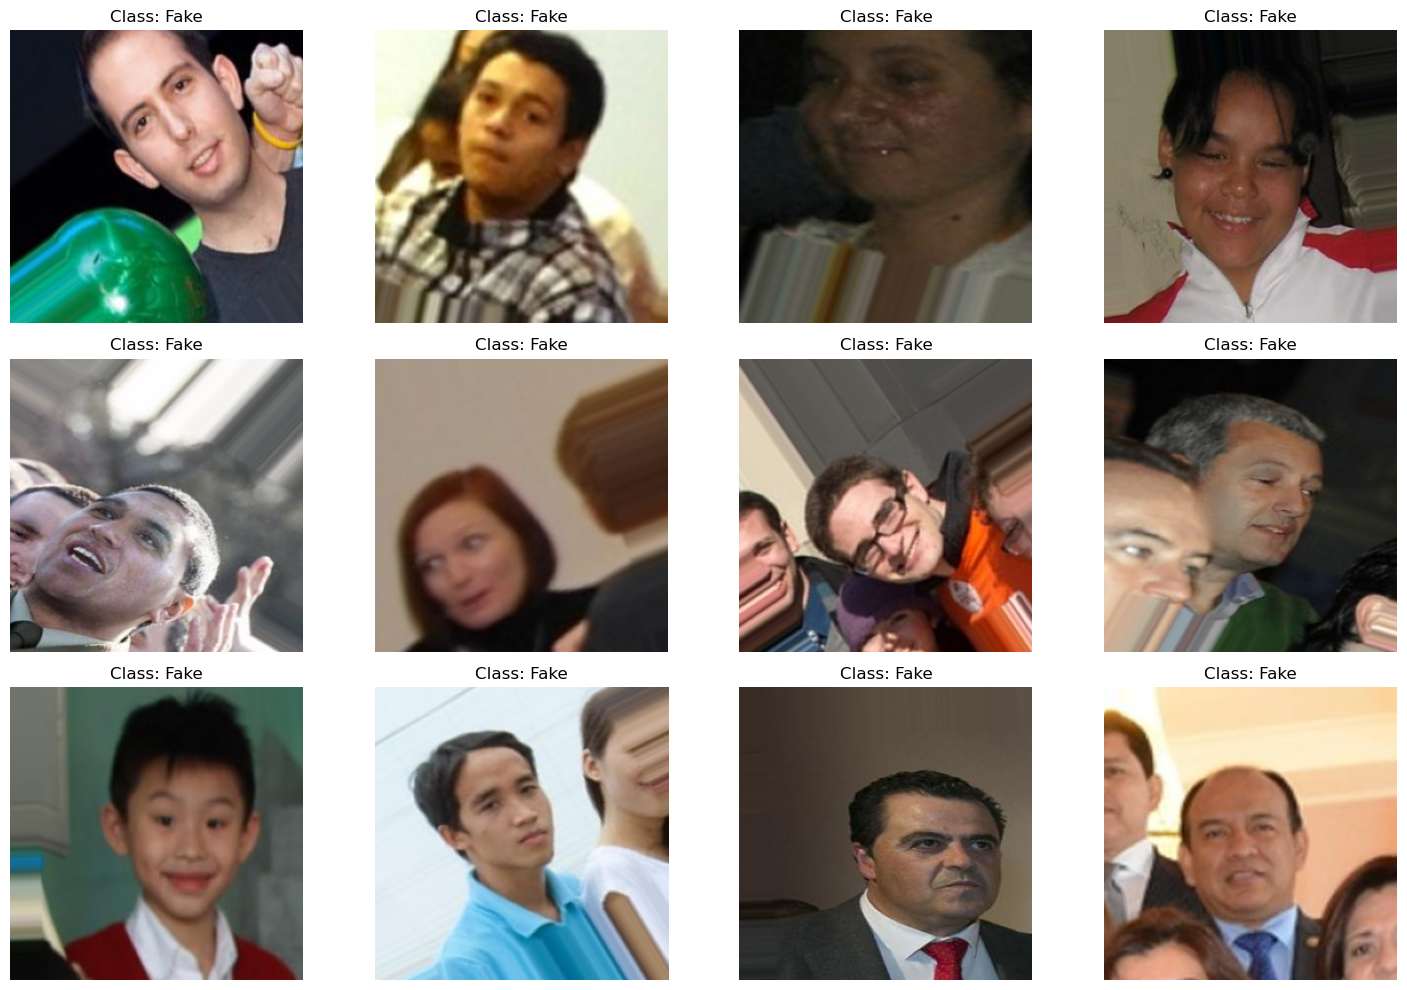

In [ ]:
# Display Sample Images
def display_sample_images():
    plt.figure(figsize=(15, 10))
    sample_batch = next(train_generator)
    images, labels = sample_batch
    
    for i in range(min(12, len(images))):
        plt.subplot(3, 4, i + 1)
        plt.imshow(images[i])
        class_idx = np.argmax(labels[i])
        plt.title(f'Class: {class_names[class_idx]}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

display_sample_images()

In [ ]:
# Build EfficientNetV2 Model with Transfer Learning
def create_efficientnet_model():
    # Load pre-trained EfficientNetV2B0 without top layers
    base_model = EfficientNetV2B0(
        weights='imagenet',
        include_top=False,
        input_shape=(IMAGE_H, IMAGE_W, CHANNELS)
    )
    
    # Freeze base model layers initially
    base_model.trainable = False
    
    # Add custom classification head
    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation='sigmoid')

    ])
    
    return model

model = create_efficientnet_model()

In [ ]:
# Model Summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b0 (Function  (None, 8, 8, 1280)       5919312   
 al)                                                             
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               1

In [ ]:
# Compile Model
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=[Precision(), 'accuracy']
)


In [ ]:
# Setup Callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        'best_deepfake_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )
]

In [ ]:
# Calculate Steps per Epoch
steps_per_epoch = train_generator.samples // BATCH_SIZE
validation_steps = validation_generator.samples // BATCH_SIZE

print(f"Steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")

Steps per epoch: 4375
Validation steps: 1232


In [ ]:
# Initial Training (Feature Extraction)
print("Starting initial training with frozen base model...")
history_1 = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=callbacks,
    verbose=1
)

Starting initial training with frozen base model...
Epoch 1/10
4375/4375 [==============================] - ETA: 0s - loss: 0.6947 - precision: 0.5014 - accuracy: 0.5013
Epoch 1: val_accuracy improved from -inf to 0.49820, saving model to best_deepfake_model.h5
4375/4375 [==============================] - 1971s 448ms/step - loss: 0.6947 - precision: 0.5014 - accuracy: 0.5013 - val_loss: 0.6932 - val_precision: 0.0000e+00 - val_accuracy: 0.4982 - lr: 0.0010
Epoch 2/10
4375/4375 [==============================] - ETA: 0s - loss: 0.6933 - precision: 0.5001 - accuracy: 0.5001
Epoch 2: val_accuracy improved from 0.49820 to 0.50180, saving model to best_deepfake_model.h5
4375/4375 [==============================] - 1332s 304ms/step - loss: 0.6933 - precision: 0.5001 - accuracy: 0.5001 - val_loss: 0.6932 - val_precision: 0.5018 - val_accuracy: 0.5018 - lr: 0.0010
Epoch 3/10
4375/4375 [==============================] - ETA: 0s - loss: 0.6932 - precision: 0.5030 - accuracy: 0.5030
Epoch 3: val_

In [ ]:
# Fine-tuning - Unfreeze Base Model
print("Unfreezing base model for fine-tuning...")
model.layers[0].trainable = True

# Use a lower learning rate for fine-tuning
# Import the required metrics
from tensorflow.keras.metrics import Precision, Recall

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE/10),
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

Unfreezing base model for fine-tuning...


In [ ]:
# Fine-tuning Training
print("Starting fine-tuning...")
history_2 = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=callbacks,
    verbose=1
)

Starting fine-tuning...
Epoch 1/10
4375/4375 [==============================] - ETA: 0s - loss: 0.3012 - accuracy: 0.8591 - precision_1: 0.8624 - recall: 0.8545
Epoch 1: val_accuracy improved from 0.50180 to 0.89382, saving model to best_deepfake_model.h5
4375/4375 [==============================] - 1394s 317ms/step - loss: 0.3012 - accuracy: 0.8591 - precision_1: 0.8624 - recall: 0.8545 - val_loss: 0.2562 - val_accuracy: 0.8938 - val_precision_1: 0.8989 - val_recall: 0.8883 - lr: 1.0000e-05
Epoch 2/10
4375/4375 [==============================] - ETA: 0s - loss: 0.1381 - accuracy: 0.9460 - precision_1: 0.9439 - recall: 0.9484
Epoch 2: val_accuracy improved from 0.89382 to 0.91741, saving model to best_deepfake_model.h5
4375/4375 [==============================] - 1340s 306ms/step - loss: 0.1381 - accuracy: 0.9460 - precision_1: 0.9439 - recall: 0.9484 - val_loss: 0.2111 - val_accuracy: 0.9174 - val_precision_1: 0.9360 - val_recall: 0.8967 - lr: 1.0000e-05
Epoch 3/10
4375/4375 [========

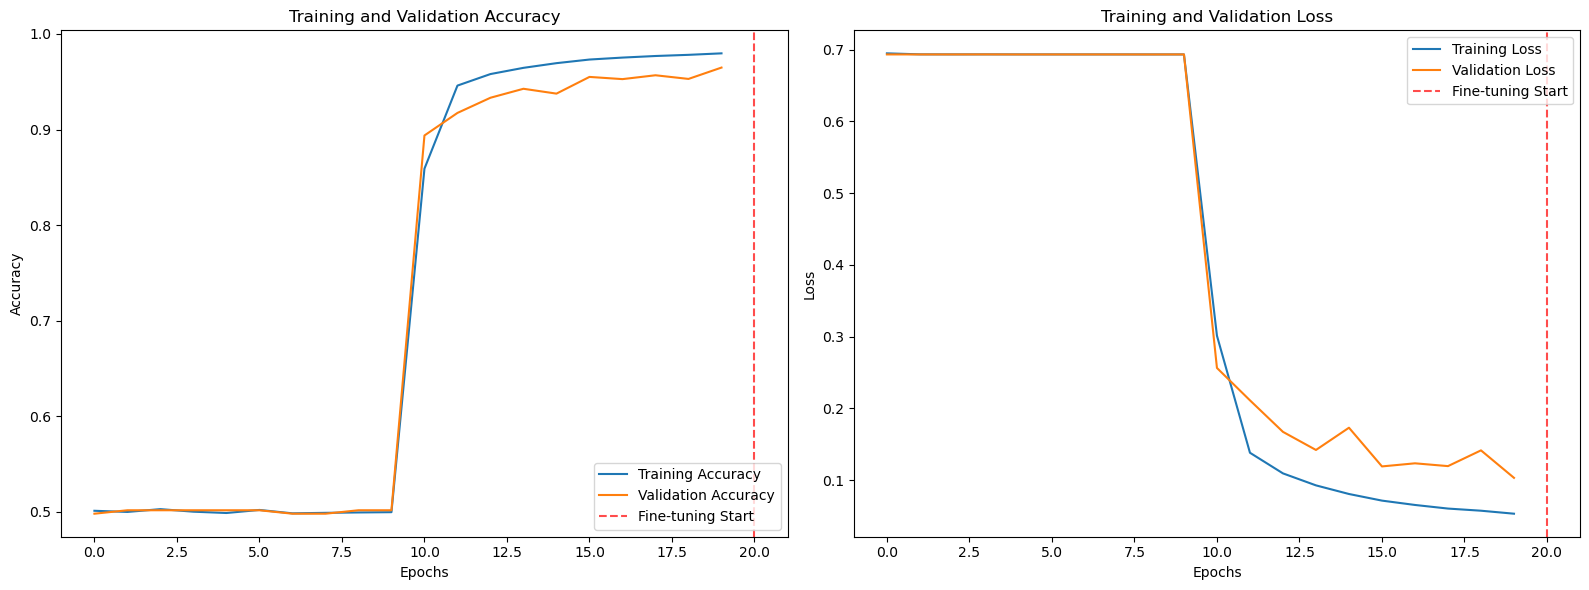

In [ ]:
# Plot Training History
def plot_training_history(history_1, history_2):
    # Combine histories
    acc = history_1.history['accuracy'] + history_2.history['accuracy']
    val_acc = history_1.history['val_accuracy'] + history_2.history['val_accuracy']
    loss = history_1.history['loss'] + history_2.history['loss']
    val_loss = history_1.history['val_loss'] + history_2.history['val_loss']
    
    epochs_range = range(len(acc))
    
    plt.figure(figsize=(16, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.axvline(x=20, color='r', linestyle='--', alpha=0.7, label='Fine-tuning Start')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.axvline(x=20, color='r', linestyle='--', alpha=0.7, label='Fine-tuning Start')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    
    plt.tight_layout()
    plt.show()

plot_training_history(history_1, history_2)


In [ ]:
# Load Best Model and Evaluate
model.load_weights('best_deepfake_model.h5')
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_generator, verbose=1)

print(f"\nTest Results:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1-Score: {2 * (test_precision * test_recall) / (test_precision + test_recall):.4f}")


341/341 [==============================] - 76s 224ms/step - loss: 0.5807 - accuracy: 0.8419 - precision_1: 0.9437 - recall: 0.7247

Test Results:
Test Loss: 0.5807
Test Accuracy: 0.8419
Test Precision: 0.9437
Test Recall: 0.7247
Test F1-Score: 0.8199


In [ ]:
# Prediction Function
def predict_image(model, img_array, class_names):
    """
    Predict single image with proper confidence calculation
    """
    # Ensure image is in correct format
    if len(img_array.shape) == 3:
        img_array = tf.expand_dims(img_array, 0)
    
    # Get prediction
    prediction = model.predict(img_array, verbose=0)
    probability = float(prediction[0][0])  # Get the probability value
    
    # Calculate confidence and predicted class
    if probability >= 0.5:
        predicted_class = class_names[1]  # Assuming class 1 is "fake"
        confidence = probability * 100
    else:
        predicted_class = class_names[0]  # Assuming class 0 is "real"
        confidence = (1 - probability) * 100
    
    return predicted_class, round(confidence, 2)


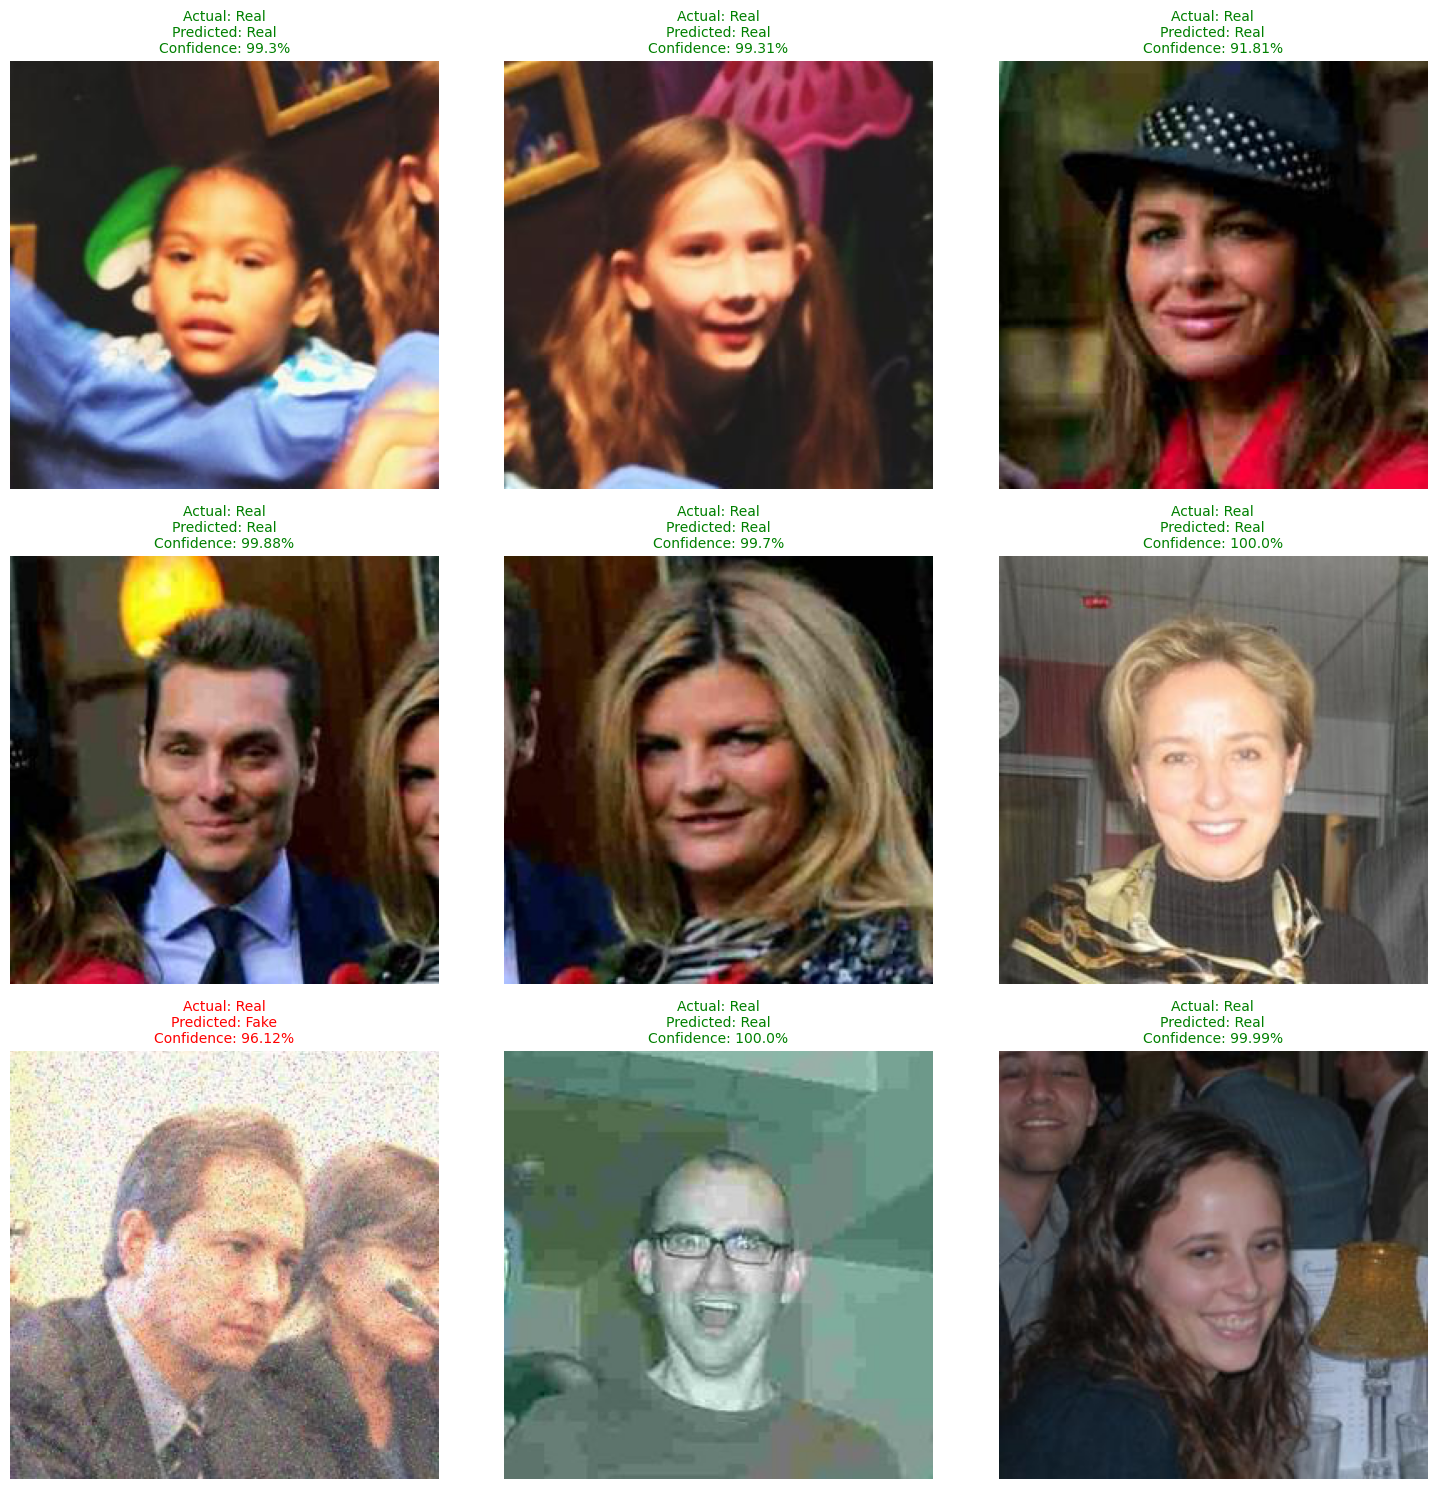

In [ ]:
# Display Test Predictions
def display_predictions():
    plt.figure(figsize=(15, 15))
    
    # Get a batch of test images
    test_images, test_labels = next(test_generator)
    
    for i in range(min(9, len(test_images))):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(test_images[i])
        
        # Get predictions
        predicted_class, confidence = predict_image(model, test_images[i], class_names)
        actual_class = class_names[int(test_labels[i])]
        
        # Color code: green for correct, red for incorrect
        color = 'green' if predicted_class == actual_class else 'red'
        
        plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence}%", 
                 color=color, fontsize=10)
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

display_predictions()

In [32]:
# Create Confusion Matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def create_confusion_matrix_fast():
    print("Creating confusion matrix (fast method)...")
    
    # Reset test generator
    test_generator.reset()
    
    # Get predictions for all test data at once
    print("Getting predictions...")
    predictions = model.predict(test_generator, verbose=1)
    
    # Get true labels
    test_generator.reset()
    y_true = test_generator.classes
    
    # Convert predictions to class predictions
    y_pred = [1 if p >= 0.5 else 0 for p in predictions.ravel()]
    
    print(f"Processed {len(y_pred)} samples")
    
    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

In [34]:
# Save Model in Different Formats
# Save complete model
model.save('deepfake_efficientnet_model.h5')
print("Model saved as deepfake_efficientnet_model.h5")

# Save as SavedModel format
model.save('deepfake_efficientnet_savedmodel')
print("Model saved as deepfake_efficientnet_savedmodel")

Model saved as deepfake_efficientnet_model.h5


KeyboardInterrupt: 

In [35]:
# Convert to TensorFlow Lite
def convert_to_tflite():
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    tflite_model = converter.convert()
    
    with open("deepfake_efficientnet_model.tflite", 'wb') as f:
        f.write(tflite_model)
    
    print("TensorFlow Lite model saved as deepfake_efficientnet_model.tflite")
    
    # Get model size
    import os
    size_mb = os.path.getsize("deepfake_efficientnet_model.tflite") / (1024 * 1024)
    print(f"TFLite model size: {size_mb:.2f} MB")

convert_to_tflite()


INFO:tensorflow:Assets written to: C:\Users\GUIN3A~1\AppData\Local\Temp\tmph14l3rm0\assets


INFO:tensorflow:Assets written to: C:\Users\GUIN3A~1\AppData\Local\Temp\tmph14l3rm0\assets


TensorFlow Lite model saved as deepfake_efficientnet_model.tflite
TFLite model size: 7.01 MB


In [36]:
# Model Performance Summary
print("\n" + "="*50)
print("MODEL PERFORMANCE SUMMARY")
print("="*50)
print(f"Architecture: EfficientNetV2B0 + Custom Head")
print(f"Input Shape: {IMAGE_H}x{IMAGE_W}x{CHANNELS}")
print(f"Classes: {class_names}")
print(f"Total Parameters: {model.count_params():,}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print("="*50)


MODEL PERFORMANCE SUMMARY
Architecture: EfficientNetV2B0 + Custom Head
Input Shape: 256x256x3
Classes: ['Fake', 'Real']
Total Parameters: 6,706,769
Test Accuracy: 0.8419
Test Precision: 0.9437
Test Recall: 0.7247
